Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.decomposition import PCA


np.random.seed(42) #Sets the random seed. 

**A place to put some functions used throughout the notebook.**

In [4]:
# Function to print a summary from dataframes. Adds skewness and kurtosis values. 
def see_summary (data_frame):
    summary = data_frame.describe(include='all').T
    summary['skewness'] = data_frame.skew()
    summary['kurtosis'] = data_frame.kurtosis()
    print(summary)

# Function to plot Distributions
def distribution (df_column, column_name):
    plt.hist(df_column,bins=25)
    plt.title(f"Histogram of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.show()

***Loading in Data and Getting the Summary Statistics***
Dropping Time_Value and Smoothed_wtested_positive_14d columns

In [6]:
# print(os.getcwd())
df = pd.read_csv('covidcast_new-1.csv')
# print (df.head())

if "time_value" in df.columns:
    df = df.drop('time_value', axis=1)

# see_summary(df)

# Dropping rows w/o the target label. 
df = df[df['smoothed_wtested_positive_14d'].notnull()]

see_summary(df)

# Checking for empty values. 
empty = df.isnull().sum()
# print(empty) 
percent_null = (empty / len(df)) * 100
null_summary = pd.DataFrame({'Null Count': empty, 'Percent Null': percent_null})
print(null_summary)

                                       count          mean           std  \
geo_value                             3994.0  26665.803205  15971.575875   
smoothed_wspent_time_1d               3873.0     29.540826      6.165547   
smoothed_wtested_14d                  3879.0     15.685206      5.090793   
smoothed_wpublic_transit_1d           3873.0      3.955646      5.141994   
smoothed_wworried_become_ill          3903.0     70.512220      5.402762   
smoothed_wvaccine_likely_govt_health  3903.0     32.974395      7.484255   
smoothed_wshop_1d                     3873.0     52.650528      4.830845   
smoothed_wtested_positive_14d         3994.0     17.250770      7.419522   
smoothed_wwork_outside_home_1d        3873.0     31.864066      5.510357   
smoothed_wothers_masked               3899.0     82.046408     13.480812   
smoothed_wcli                         3859.0      1.061285      0.508627   
smoothed_wcovid_vaccinated            3894.0     12.434098      6.143912   
smoothed_wva

Making Histograms for each column in the data frame.

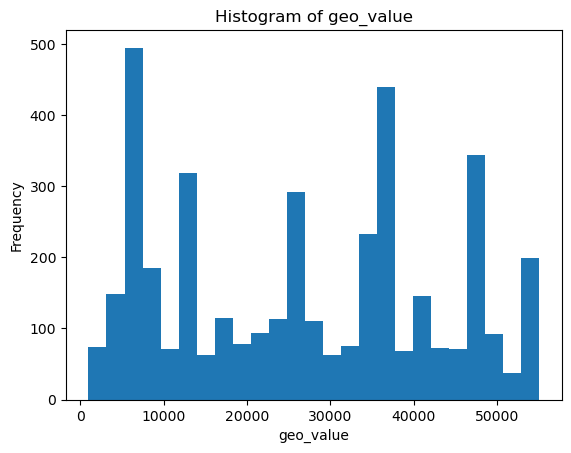

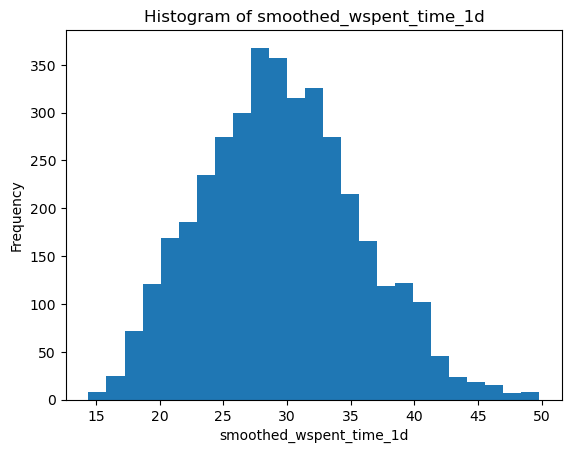

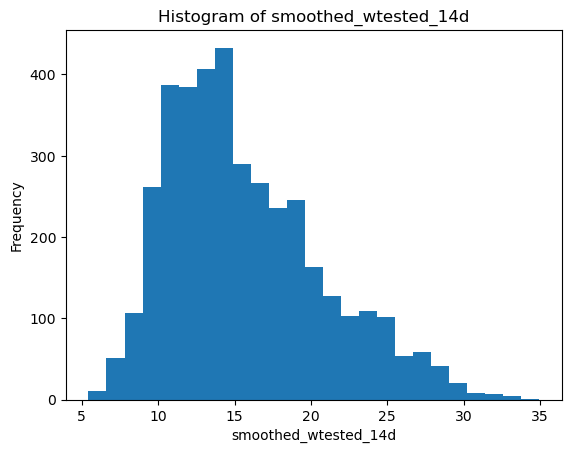

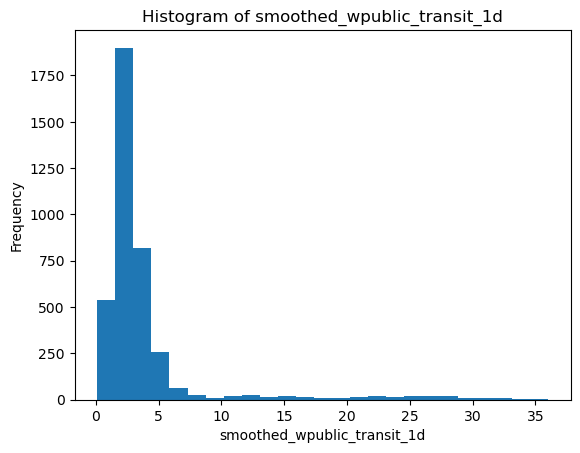

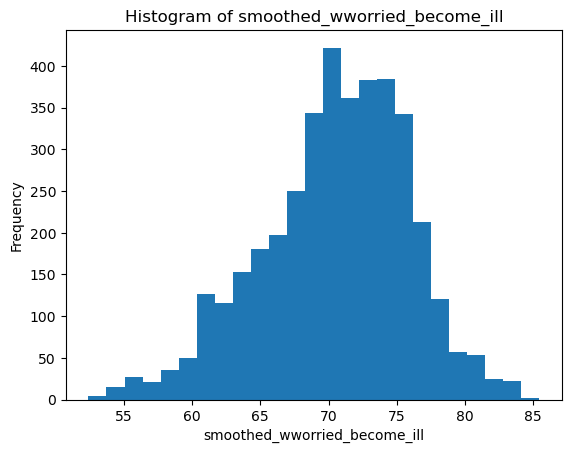

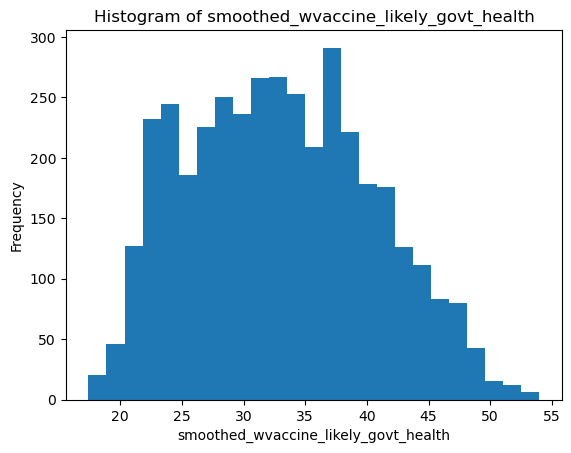

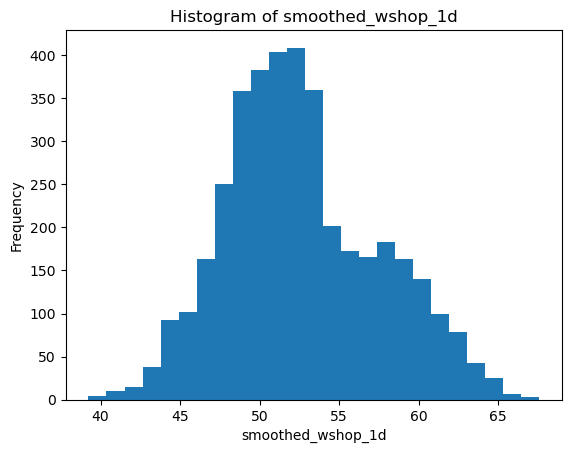

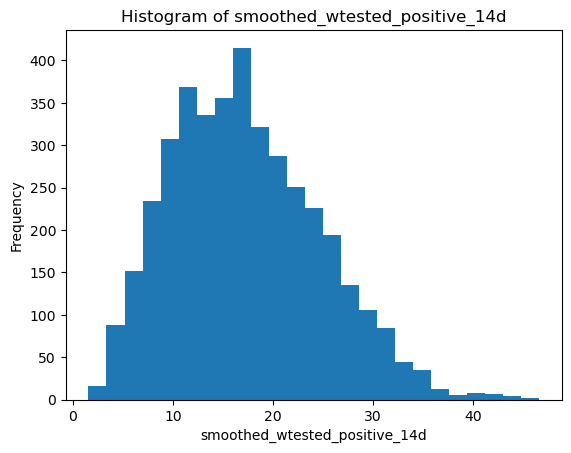

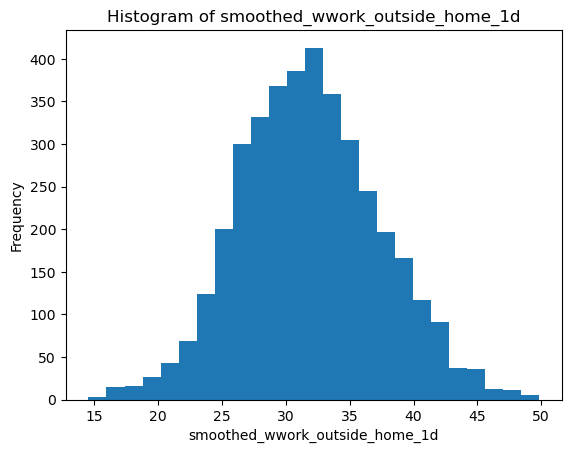

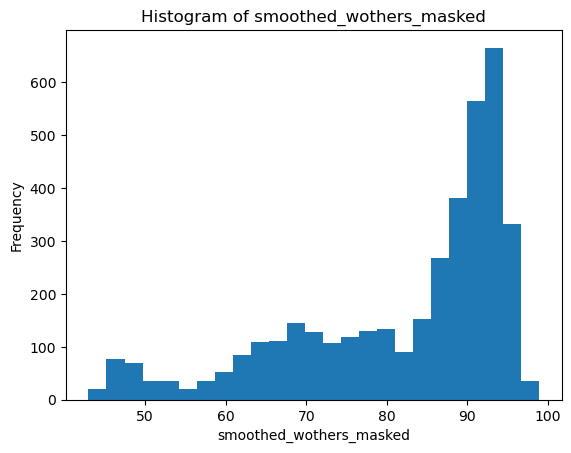

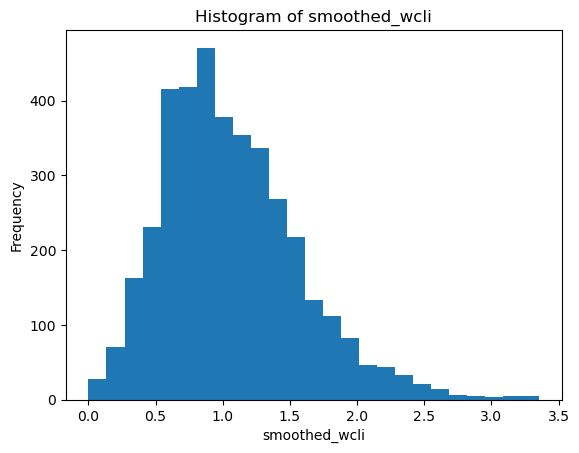

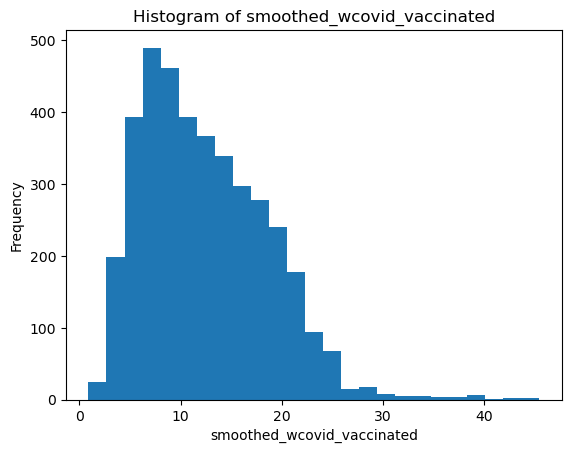

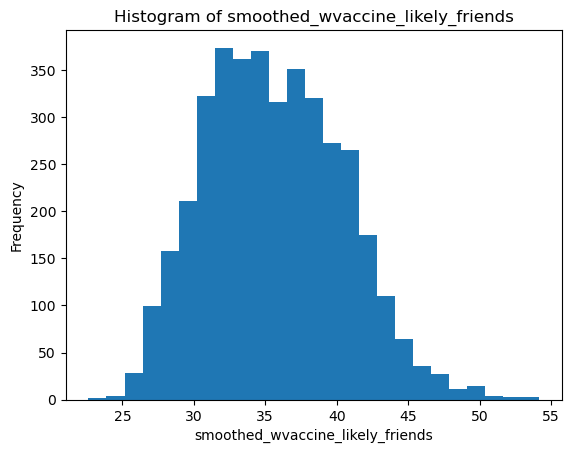

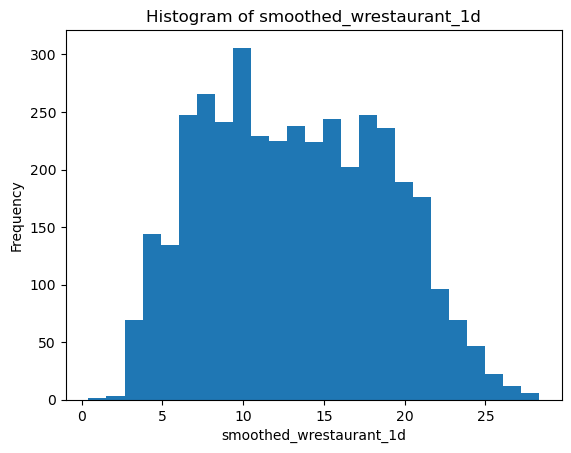

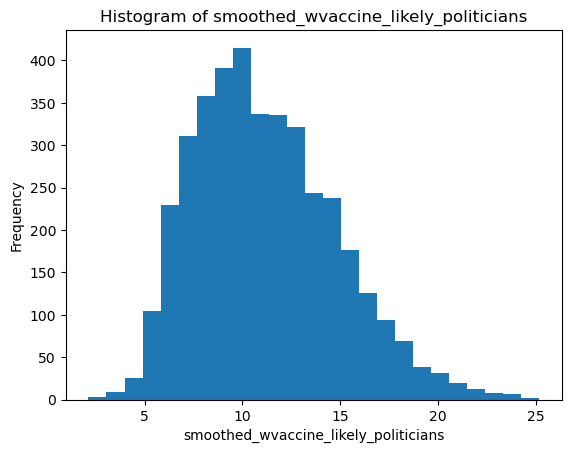

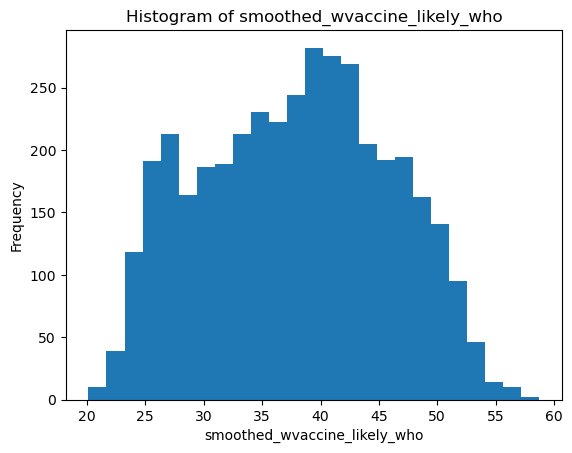

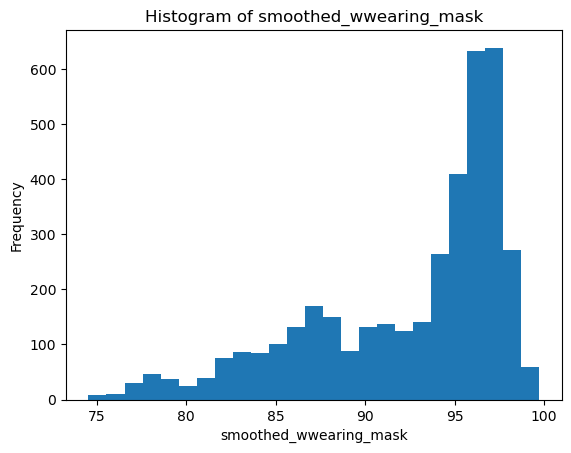

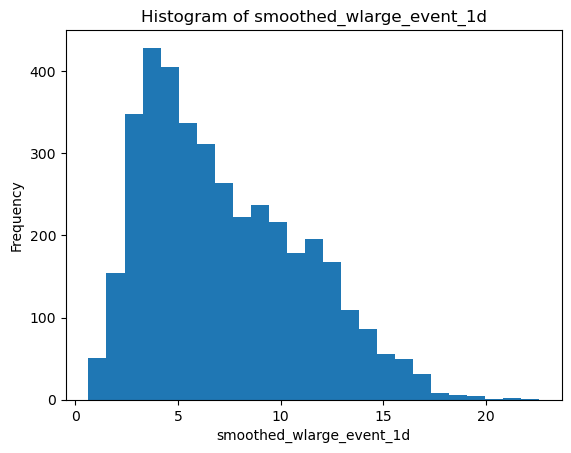

In [8]:
for col in df.columns:
    distribution(df[col], col)

**Removing Geo_Value from the data frame.** 

In [10]:
# Drop Geo_Value
if "geo_value" in df.columns:  
    df = df.drop('geo_value', axis=1)

# print (df.columns)

Visualize a correlation matrix

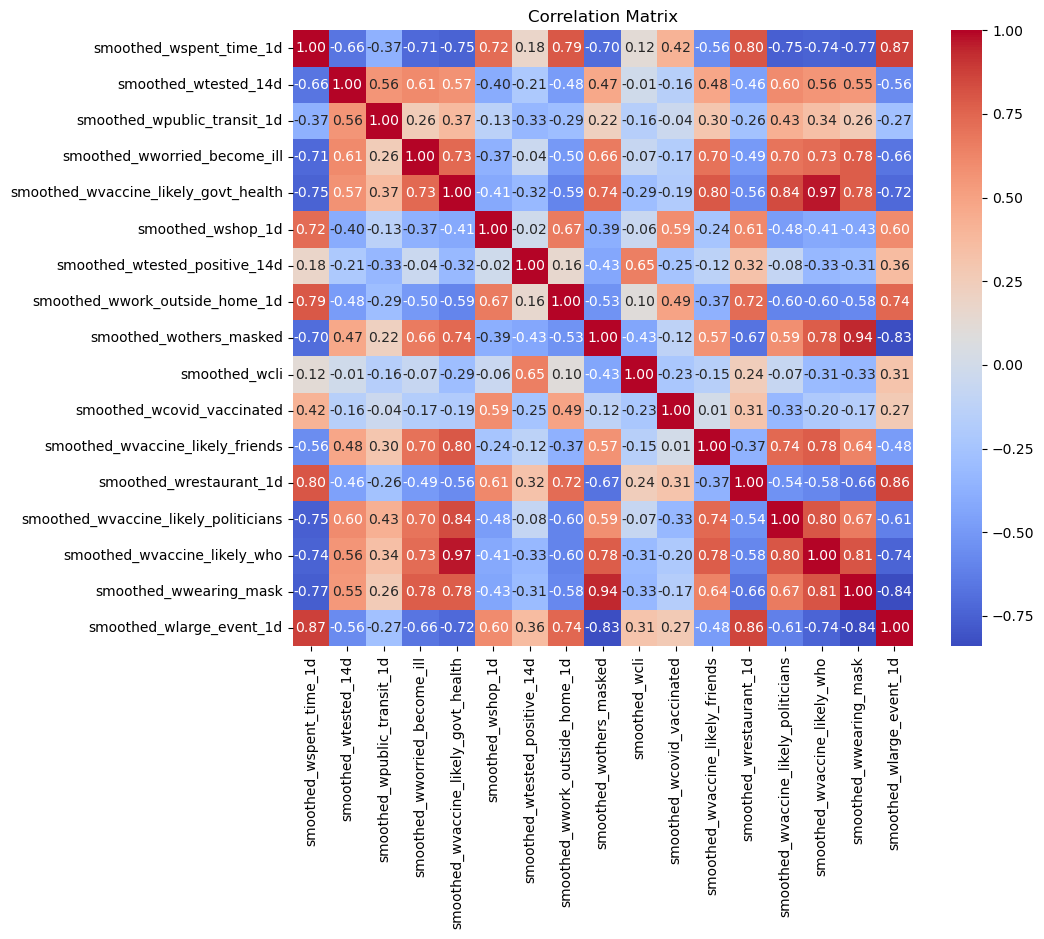

In [12]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Now, looking at dropping unreliable instances in the dataset. Set the threshold to 51% So anything less would be dropped.  

In [14]:
# Testing the threshold feature here. 
threshold = df.shape[1] * 0.51
print (threshold)
print(len(df))
df_test = df.dropna(thresh=threshold)
print(len(df_test))

8.67
3994
3881


In [15]:
df= df.dropna(thresh=threshold)

see_summary(df)

                                       count       mean        std        min  \
smoothed_wspent_time_1d               3873.0  29.540826   6.165547  14.410554   
smoothed_wtested_14d                  3878.0  15.683821   5.090718   5.437303   
smoothed_wpublic_transit_1d           3873.0   3.955646   5.141994   0.115497   
smoothed_wworried_become_ill          3878.0  70.490606   5.395952  52.405818   
smoothed_wvaccine_likely_govt_health  3877.0  32.970862   7.493678  17.410006   
smoothed_wshop_1d                     3873.0  52.650528   4.830845  39.237833   
smoothed_wtested_positive_14d         3881.0  17.417078   7.426650   1.548609   
smoothed_wwork_outside_home_1d        3873.0  31.864066   5.510357  14.558697   
smoothed_wothers_masked               3877.0  81.978574  13.484213  42.950717   
smoothed_wcli                         3858.0   1.061560   0.508406   0.000000   
smoothed_wcovid_vaccinated            3879.0  12.459743   6.141449   0.891041   
smoothed_wvaccine_likely_fri

Filling in missing values using a normal distribution if we can assume normality when examining kurtosis and skewness. If not using the median value instead of the mean to fill the value.  

In [17]:
for col in df.columns:
    if df[col].skew() > 1 or df[col].skew() < -1 or df[col].kurtosis() > 3 or df[col].kurtosis() < 0: #Indicates not normally distributed.Use median to fill missing values. 
        if df[col].isnull().any():
            median = df[col].median()
            std = df[col].std()
            num_missing = df[col].isnull().sum()
            random_values = np.random.normal(loc=median, scale=std, size=num_missing)
            df.loc[df[col].isnull(), col] = random_values
    else: 
        if df[col].isnull().any():
            mean = df[col].mean()
            std = df[col].std()
            num_missing = df[col].isnull().sum()
            random_values = np.random.normal(loc=mean, scale=std, size=num_missing)
            df.loc[df[col].isnull(), col] = random_values

# print(df.isnull().sum()) # A check to ensure there are no missing values in the dataset. 

In [18]:
see_summary(df)

                                       count       mean        std        min  \
smoothed_wspent_time_1d               3881.0  29.547202   6.163782  14.410554   
smoothed_wtested_14d                  3881.0  15.683309   5.089229   5.437303   
smoothed_wpublic_transit_1d           3881.0   3.944756   5.145345  -7.289100   
smoothed_wworried_become_ill          3881.0  70.490366   5.396782  52.405818   
smoothed_wvaccine_likely_govt_health  3881.0  32.967158   7.492192  17.410006   
smoothed_wshop_1d                     3881.0  52.647410   4.830428  39.237833   
smoothed_wtested_positive_14d         3881.0  17.417078   7.426650   1.548609   
smoothed_wwork_outside_home_1d        3881.0  31.860306   5.510784  14.558697   
smoothed_wothers_masked               3881.0  81.975541  13.479502  42.950717   
smoothed_wcli                         3881.0   1.061778   0.507946   0.000000   
smoothed_wcovid_vaccinated            3881.0  12.459294   6.140299   0.891041   
smoothed_wvaccine_likely_fri

***Now, transforming the columns to make them approximately normal for our models.***

In [20]:
scalar = MinMaxScaler()
robust = RobustScaler()

for col in df.columns:
    if col == 'smoothed_wpublic_transit_1d':
        min_val = df['smoothed_wpublic_transit_1d'].min()
        shift_amount = abs(min_val) + 0.1 # Making the values non-negative before using the log function here. 
        df['smoothed_wpublic_transit_1d'] = np.log1p(df['smoothed_wpublic_transit_1d'] + shift_amount)
        df['smoothed_wpublic_transit_1d'] = winsorize(df['smoothed_wpublic_transit_1d'], limits=[0.01, 0.065]) #Winsorizing the data is a bit extreme but it caps all the outliers from this feature.
        df[['smoothed_wpublic_transit_1d']] = robust.fit_transform(df[['smoothed_wpublic_transit_1d']] )  
    elif df[col].skew() > 1 or df[col].skew() < -1:
        if df[col].kurtosis() > 3 or df[col].kurtosis() < 0:
            df[col] = np.log1p(df[col] - df[col].min() + 1)
        df[[col]] = scalar.fit_transform(df[[col]])

see_summary(df)

                                       count       mean       std        min  \
smoothed_wspent_time_1d               3881.0  29.547202  6.163782  14.410554   
smoothed_wtested_14d                  3881.0  15.683309  5.089229   5.437303   
smoothed_wpublic_transit_1d           3881.0   0.300209  1.147643  -1.299343   
smoothed_wworried_become_ill          3881.0  70.490366  5.396782  52.405818   
smoothed_wvaccine_likely_govt_health  3881.0  32.967158  7.492192  17.410006   
smoothed_wshop_1d                     3881.0  52.647410  4.830428  39.237833   
smoothed_wtested_positive_14d         3881.0  17.417078  7.426650   1.548609   
smoothed_wwork_outside_home_1d        3881.0  31.860306  5.510784  14.558697   
smoothed_wothers_masked               3881.0   0.697056  0.240769   0.000000   
smoothed_wcli                         3881.0   1.061778  0.507946   0.000000   
smoothed_wcovid_vaccinated            3881.0  12.459294  6.140299   0.891041   
smoothed_wvaccine_likely_friends      38

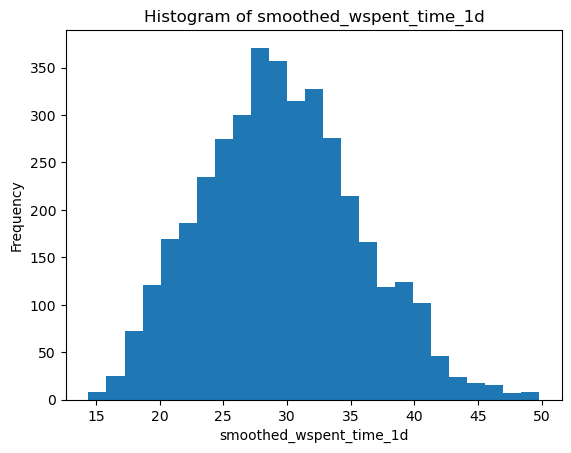

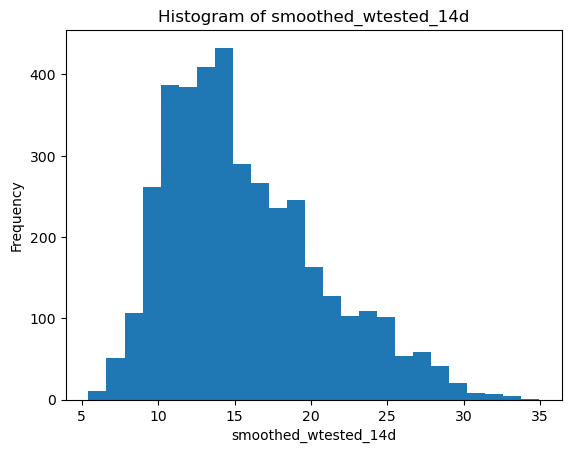

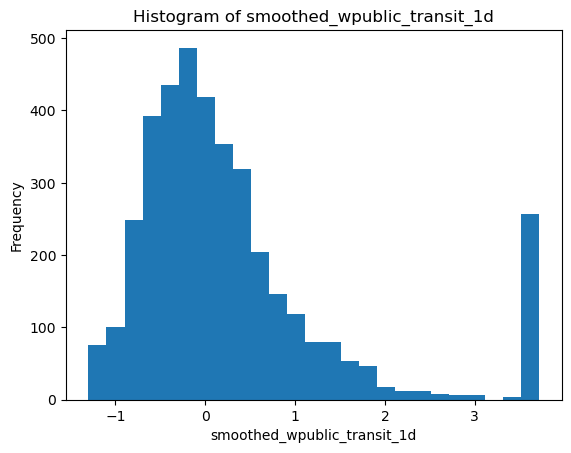

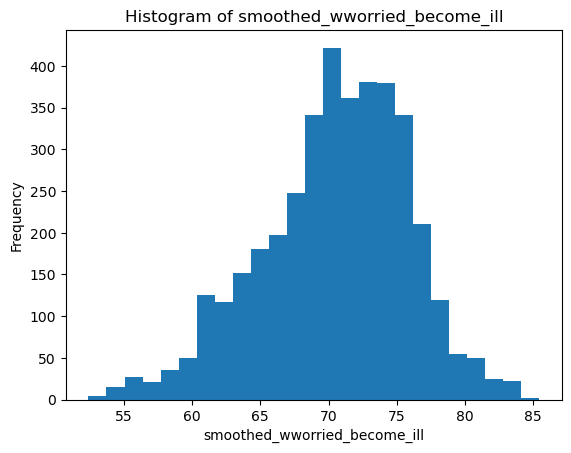

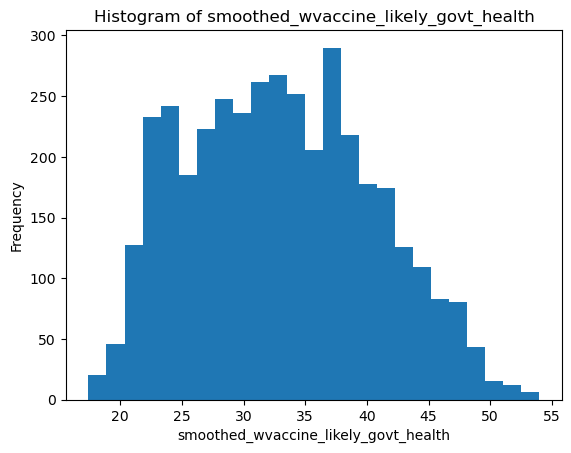

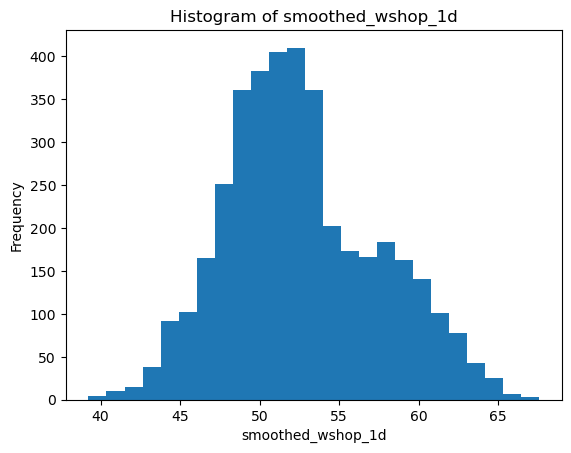

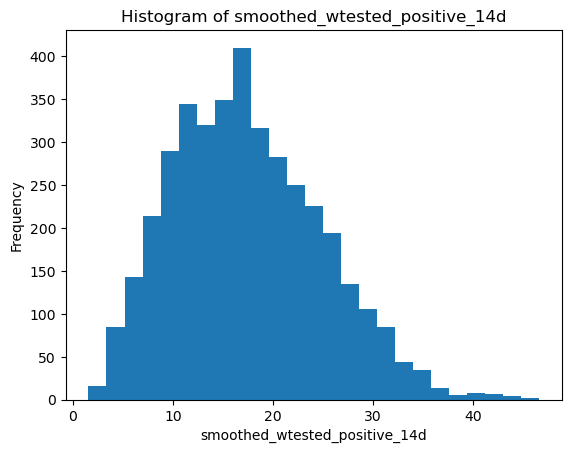

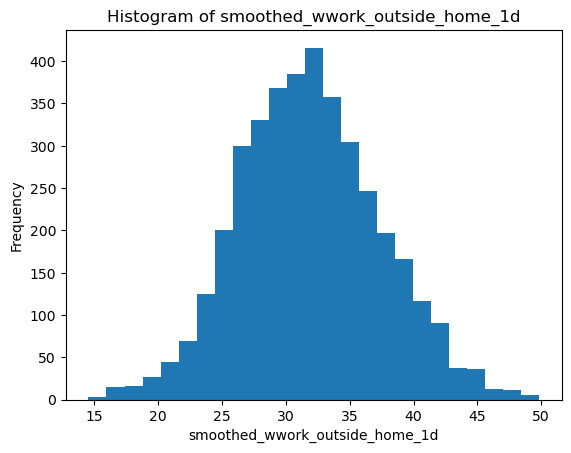

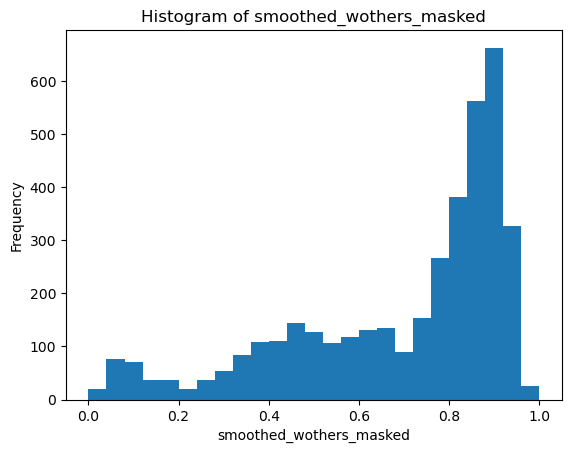

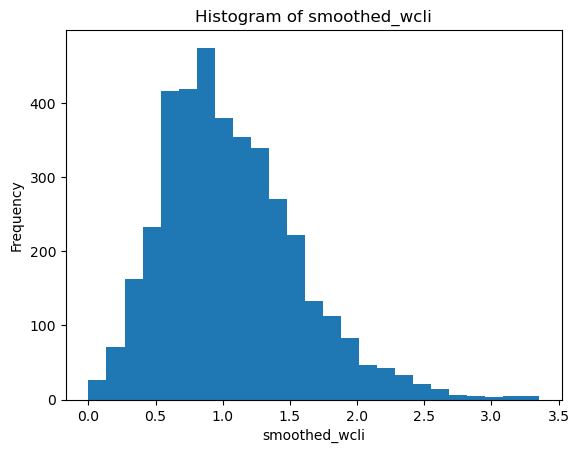

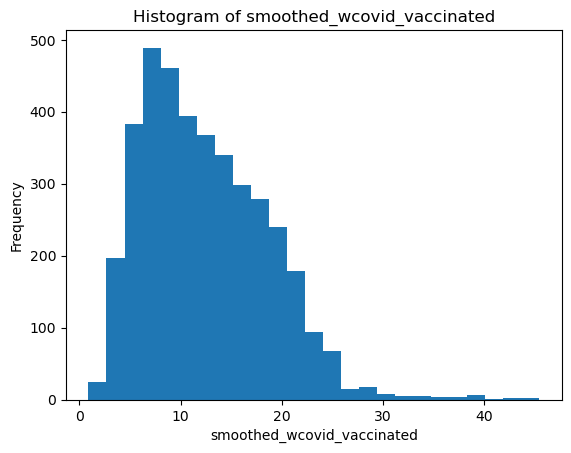

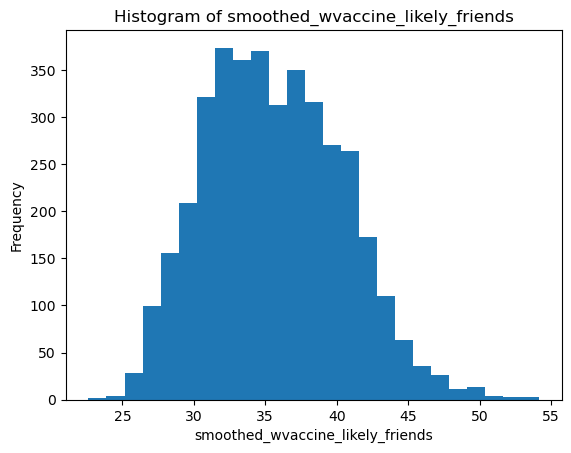

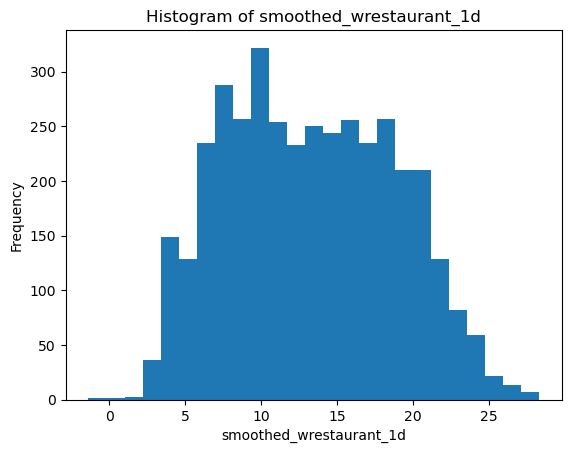

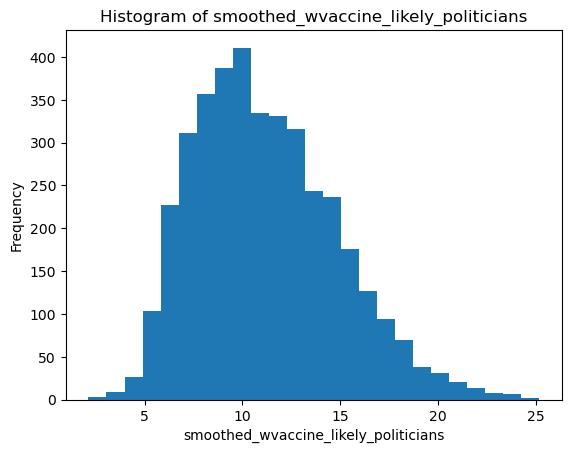

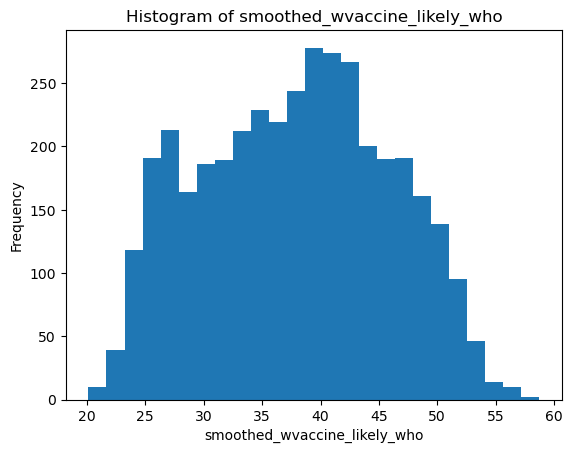

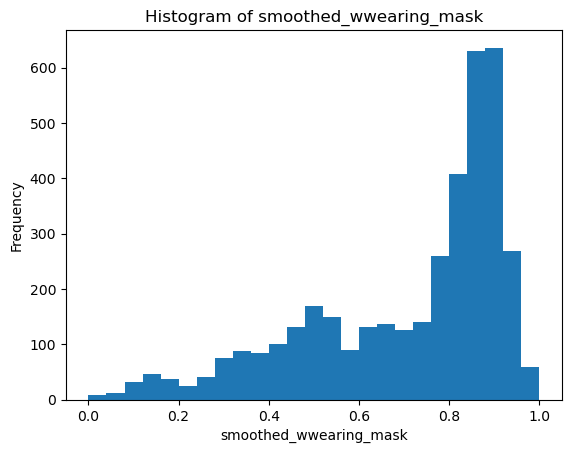

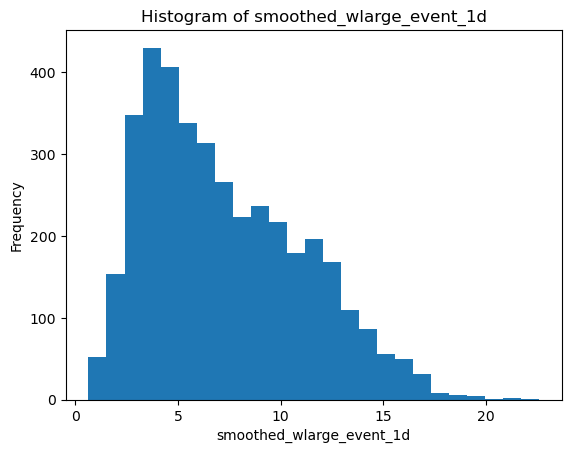

In [21]:
for col in df.columns:
    distribution(df[col], col)

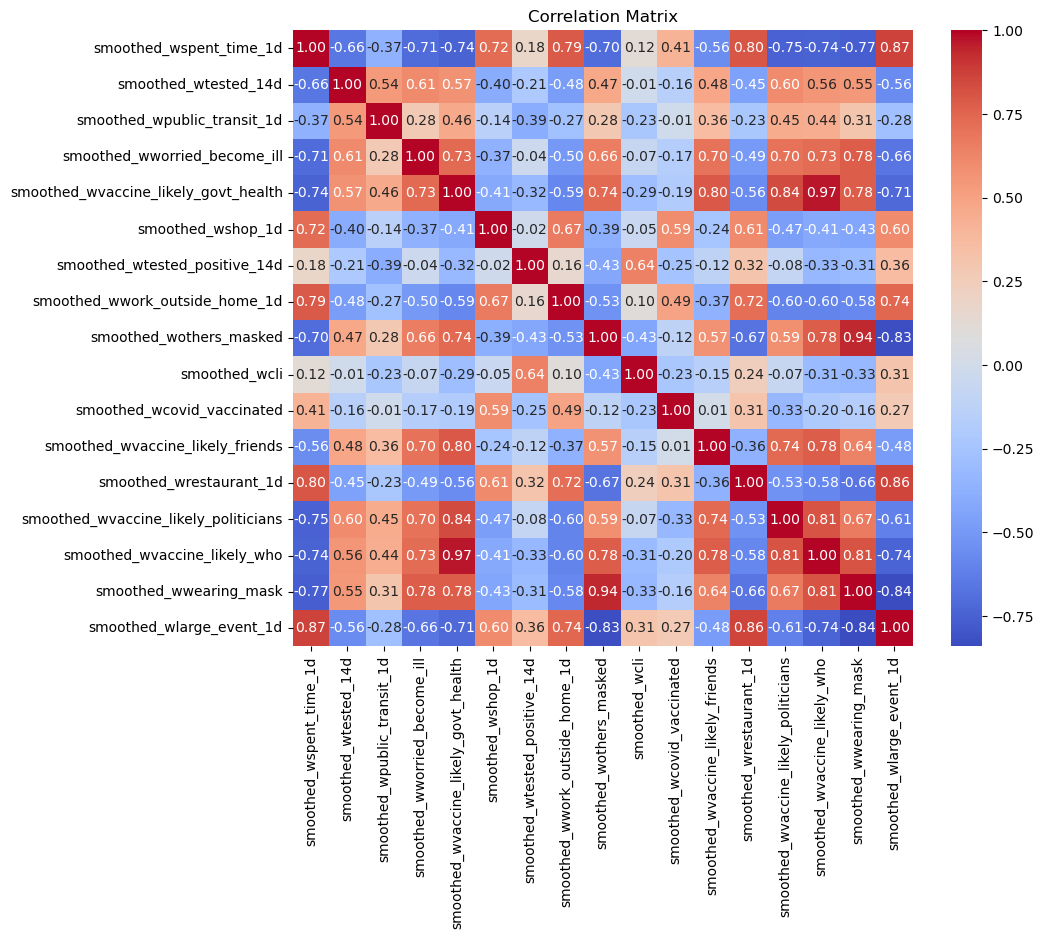

In [22]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [23]:
# Calculate VIF for each feature
vif = pd.DataFrame({
    "Feature": df.columns,
    "VIF": [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
})

print("\nVariance Inflation Factor (VIF):")
print(vif.sort_values(by="VIF", ascending=False))


Variance Inflation Factor (VIF):
                                 Feature         VIF
14          smoothed_wvaccine_likely_who  487.872251
4   smoothed_wvaccine_likely_govt_health  459.513086
3           smoothed_wworried_become_ill  451.506093
5                      smoothed_wshop_1d  332.463854
11      smoothed_wvaccine_likely_friends  224.904295
0                smoothed_wspent_time_1d  213.990810
15                smoothed_wwearing_mask  171.901531
7         smoothed_wwork_outside_home_1d  116.478312
8                smoothed_wothers_masked  116.189655
13  smoothed_wvaccine_likely_politicians   54.870675
16              smoothed_wlarge_event_1d   52.252252
12               smoothed_wrestaurant_1d   30.352951
1                   smoothed_wtested_14d   27.270011
6          smoothed_wtested_positive_14d   17.708139
9                          smoothed_wcli   11.124711
10            smoothed_wcovid_vaccinated   10.456908
2            smoothed_wpublic_transit_1d    2.071089


**The Data is preprocessed to a point where most appears normally distributed. You can see from the correlation matrix and VIF at the end we have some multicollinear relationships. I did not remove them because some of our models would do it themselves.**

In [25]:
#For Question 1:
# Drop smoothed wtested positive 14d
x1 = df.drop('smoothed_wtested_positive_14d', axis=1)
# dataframe with only the target label. 
y1 = df['smoothed_wtested_positive_14d']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42) #If we want to use this. 

#For Question 2: 
# Drop smoothed wcovid vaccinated
x2 = df.drop('smoothed_wcovid_vaccinated', axis=1)
# dataframe with only the target label. 
y2 = df['smoothed_wcovid_vaccinated']

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

***Functions for Learning***

In [27]:
def linear_model(x_train, x_test, y_train, y_test):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)

    y_pred_lr = lr_model.predict(x_test)

    print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
    print("Linear Regression RMSE:", mean_squared_error(y_test, y_pred_lr))

# Want to see if there is much difference in the baseline when using cross-validation.
def cross_validated_lm(x, y, split): # x: feature variables, y: target variables, split: folds. 
    lm = LinearRegression()    
    kf = KFold(n_splits=split, shuffle=True, random_state=42)

    r2_scores = cross_val_score(lm, x, y, cv=kf, scoring="r2")
    rmse_scores = -cross_val_score(lm, x, y, cv=kf, scoring="neg_root_mean_squared_error")

    print(f"Mean R²: {r2_scores.mean():.4f}")
    print(f"Mean RMSE: {rmse_scores.mean():.4f}")

def cross_validated_Regularization(model_name, x, y, alpha, split): # model_name: Lasso or Ridge, x: features, y: targets, alpha: penalty, split: folds.

    if model_name == ElasticNet:
        model = model_name(alpha=alpha, l1_ratio=0.5)
    else:
        model = model_name(alpha=alpha)
        
    kf = KFold(n_splits=split, shuffle=True, random_state=42)

    r2_scores = cross_val_score(model, x, y, cv=kf, scoring="r2")
    rmse_scores = -cross_val_score(model, x, y, cv=kf, scoring="neg_root_mean_squared_error")
    
    return (model_name, alpha, r2_scores.mean(), rmse_scores.mean())

def best_model_description (model_name, x_train, x_test, y_train, y_test, alpha):
    if model_name == ElasticNet:
        model = model_name(alpha=alpha, l1_ratio=0.5)
    else:
        model = model_name(alpha=alpha)

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)

    coefficients = model.coef_
    feature_weights = pd.Series(coefficients, index=x_train.columns)

    print(feature_weights.sort_values(ascending=False))

Baseline Models:

In [29]:
print ("Baseline 1 Target (smoothed wtested positive 14d)")
linear_model(x1_train, x1_test, y1_train, y1_test)

print ("Baseline 2 Target (smoothed wcovid vaccinated)")
linear_model(x2_train, x2_test, y2_train, y2_test)

Baseline 1 Target (smoothed wtested positive 14d)
Linear Regression R²: 0.6117156036694975
Linear Regression RMSE: 21.27385471734273
Baseline 2 Target (smoothed wcovid vaccinated)
Linear Regression R²: 0.582592164522707
Linear Regression RMSE: 14.869044166699846


Baseline Model using Cross-Validation

In [31]:
print ("Baseline 1 Target (smoothed wtested positive 14d)")
cross_validated_lm(x1, y1, 10) 
print ("Baseline 2 Target (smoothed wcovid vaccinated)")
cross_validated_lm(x2, y2, 10) 

Baseline 1 Target (smoothed wtested positive 14d)
Mean R²: 0.6286
Mean RMSE: 4.5189
Baseline 2 Target (smoothed wcovid vaccinated)
Mean R²: 0.5377
Mean RMSE: 4.1680


Ridge and Lasso Regression Models

In [33]:

alphas = [0.001, 0.01, 1, 10, 100] #Tuning the penalty for these models. 
models = [Lasso, Ridge, ElasticNet] #Determing which regression to use. 

best_model = None
best_alpha = None
best_r2 = None
best_rmse = float('inf')

print("First Target")
for a in alphas: 
    for m in models:
        model, alpha, r2, rmse = cross_validated_Regularization(m, x1_train, y1_train, a, 10)
        if rmse < best_rmse:
            best_model = model
            best_alpha = alpha
            best_r2 = r2
            best_rmse = rmse
            
print(f"The best model is: {best_model. __name__} with an alpha of {best_alpha}. \nR^2: {best_r2:.4f} \nRMSE: {best_rmse:.4f}")

best_model_description (best_model , x1_train, x1_test, y1_train, y1_test, best_alpha)

best_model_2 = None
best_alpha_2 = None
best_r2_2 = None
best_rmse_2 = float('inf')

print("Second Target")
for a in alphas: 
    for m in models:
        model, alpha, r2, rmse = cross_validated_Regularization(m, x2_train, y2_train, a, 10)
        if rmse < best_rmse:
            best_model_2 = model
            best_alpha_2 = alpha
            best_r2_2 = r2
            best_rmse_2 = rmse

print(f"The best model is: {best_model_2. __name__} with an alpha of {best_alpha_2}. \nR^2: {best_r2_2:.4f} \nRMSE: {best_rmse_2:.4f}")

best_model_description (best_model , x2_train, x2_test, y2_train, y2_test, best_alpha_2)

First Target
The best model is: Ridge with an alpha of 0.01. 
R^2: 0.6321 
RMSE: 4.4946
smoothed_wwearing_mask                  10.351066
smoothed_wcli                            4.960262
smoothed_wvaccine_likely_politicians     0.533502
smoothed_wlarge_event_1d                 0.373462
smoothed_wworried_become_ill             0.321111
smoothed_wvaccine_likely_friends         0.260996
smoothed_wrestaurant_1d                  0.213972
smoothed_wwork_outside_home_1d           0.034709
smoothed_wvaccine_likely_who             0.033909
smoothed_wshop_1d                       -0.090049
smoothed_wspent_time_1d                 -0.179334
smoothed_wcovid_vaccinated              -0.211614
smoothed_wtested_14d                    -0.232205
smoothed_wvaccine_likely_govt_health    -0.450208
smoothed_wpublic_transit_1d             -1.489093
smoothed_wothers_masked                -11.800190
dtype: float64
Second Target
The best model is: Ridge with an alpha of 100. 
R^2: 0.5222 
RMSE: 4.2524
smoothed_

**Feature Selection**

smoothed_wcli                           0.644866
smoothed_wlarge_event_1d                0.362287
smoothed_wrestaurant_1d                 0.316785
smoothed_wspent_time_1d                 0.178562
smoothed_wwork_outside_home_1d          0.157035
smoothed_wshop_1d                      -0.019185
smoothed_wworried_become_ill           -0.042193
smoothed_wvaccine_likely_politicians   -0.084647
smoothed_wvaccine_likely_friends       -0.119244
smoothed_wtested_14d                   -0.212765
smoothed_wcovid_vaccinated             -0.254523
smoothed_wwearing_mask                 -0.305986
smoothed_wvaccine_likely_govt_health   -0.317712
smoothed_wvaccine_likely_who           -0.326254
smoothed_wpublic_transit_1d            -0.391650
smoothed_wothers_masked                -0.425991
Name: target, dtype: float64


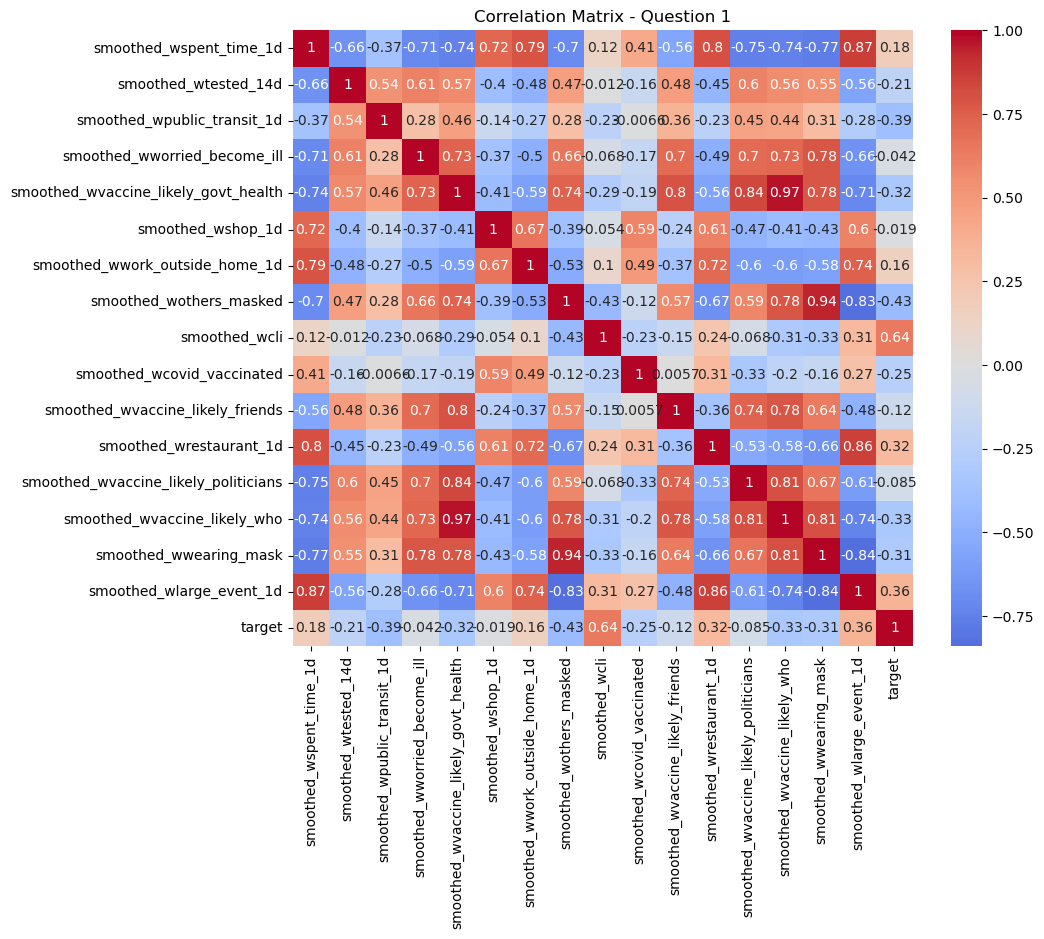

smoothed_wshop_1d                       0.593360
smoothed_wwork_outside_home_1d          0.493420
smoothed_wspent_time_1d                 0.414895
smoothed_wrestaurant_1d                 0.312001
smoothed_wlarge_event_1d                0.269740
smoothed_wvaccine_likely_friends        0.005683
smoothed_wpublic_transit_1d            -0.006584
smoothed_wothers_masked                -0.120322
smoothed_wtested_14d                   -0.156850
smoothed_wwearing_mask                 -0.164796
smoothed_wworried_become_ill           -0.171622
smoothed_wvaccine_likely_govt_health   -0.186620
smoothed_wvaccine_likely_who           -0.201994
smoothed_wcli                          -0.227072
smoothed_wtested_positive_14d          -0.254523
smoothed_wvaccine_likely_politicians   -0.327793
Name: target, dtype: float64
Reduced to 9 principal components
Reduced to 9 principal components


In [57]:
df1_corr = x1.copy()
df1_corr['target'] = y1

correlations_q1 = df1_corr.corr()['target'].drop('target') 

print(correlations_q1.sort_values(ascending=False))

plt.figure(figsize=(10, 8))
sns.heatmap(df1_corr.corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix - Question 1")
plt.show()

df2_corr = x2.copy()
df2_corr['target'] = y2

correlations_q2 = df2_corr.corr()['target'].drop('target')

print(correlations_q2.sort_values(ascending=False))

scaler = StandardScaler()
x_scaled_1 = scaler.fit_transform(x1)
x_scaled_2 = scaler.fit_transform(x2)


pca = PCA(n_components=0.95)  # Keep 95% of variance
x1_pca = pca.fit_transform(x_scaled_1)
x2_pca = pca.fit_transform(x_scaled_2)

print(f"Reduced to {x1_pca.shape[1]} principal components")
print(f"Reduced to {x2_pca.shape[1]} principal components")